In [1]:
import os
from src import *
from src.adult_data import *
from src.compas_data import *
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

"""
COMPAS:
BL   African-American    3696                          
WH   Caucasian           2454                            
HI   Hispanic             637
OT   Other                377
As   Asian                 32 (merged with Other)
Na?   Native American       18 (merged with Other)

ADULT:
IN   Amer-Indian-Eskimo  count: 311
WH   White               count: 27816
AP   Asian-Pac-Islander  count: 1039
BL   Black               count: 3124
OT   Other               count: 271
""" 

race_label = {"Caucasian":'WH', "Hispanic":"HI", "African-American": "BL",
              "White":"WH", 'Asian-Pac-Islander':"AP", "Black":"BL",
              'Amer-Indian-Eskimo':"IN", 'Other':"OT"}

color_map = {
    "OT": "#2ba779",
    "WH": "#264ba9",
    "AP": "#842ab7",
    "BL": "#d47520",
    "IN": "#ecd604",
    "HI": "#ecd604"    
}

other = {Tester.OPT_ALL_RACE_SPLITS: True}
Tester.VERBOSE = False
other_fb = other.copy()
other_fb[BaseModel.OPT_FBALANCE] = True
all_metrics = Metrics.get_all_names()
Metrics.OPT_PRETTY_LABELS = True

datasets =  [Tester.COMPAS_D, Tester.ADULT_D]
mls_basic = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       None,    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, None,    other)
}

Y_LABEL = None
Y_LABELSUPER = None
X_LABEL = None
X_LABELSUPER = None

plot_h = 4.5


In [2]:
data = AdultData()
#print("ADULT")
data.print_data_stats()

data = CompasData()
#print("COMPAS")
data.print_data_stats()

POS: w, m, tot, COUNT: w, m, tot, for race 
0.118953945845869,0.31756545321789925,0.2558599367270636,8642,19174,27816,White
0.05787781350482315,0.18929254302103252,0.12387964148527529,1555,1569,3124,Black
0.12427745664739884,0.3362193362193362,0.26564003849855633,346,693,1039,Asian-Pac-Islander
0.10084033613445378,0.125,0.1157556270096463,119,192,311,Amer-Indian-Eskimo
0.05504587155963303,0.11728395061728394,0.09225092250922509,109,162,271,Other
0.10946058861758426,0.3057365764111978,0.2408095574460244,10771,21790,32561,all
POS: w, m, tot, COUNT: w, m, tot, for race 
0.75,0.6260623229461756,0.6470588235294118,72,353,425,Other
0.6234567901234568,0.45586297760210803,0.48534201954397393,648,3036,3684,African-American
0.648936170212766,0.5943646996278575,0.6069529652351738,564,1881,2445,Caucasian
0.6796116504854369,0.6306818181818182,0.6386687797147385,103,528,631,Hispanic
0.6445565969718817,0.5270783028630562,0.5497564370215727,1387,5798,7185,all


## ALL METRICS TABLE

In [3]:
# 1 file each for compas and adult tables. 
# func input: dataset, reps, metrics?, filename

def all_race_splits(dataset, reps, filename, metrics = all_metrics, clear_file = True, attrs = None):
    file = os.path.join("results",filename +".csv")
    errors = os.path.join("results",filename +"errors.txt")
    if clear_file and os.path.exists(file): os.remove(file)
    if clear_file and os.path.exists(errors): os.remove(errors)
    f = open(errors, 'w')
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()):
        f.writelines([f"\n\n{bias_mit}\n"])
        oth[tester.OPT_SPLIT_RACE_COLS] = False
        oth[tester.OPT_ALL_RACE_SPLITS] = True
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        err = tester.get_exceptions()
        f.writelines([f"{line}\n" for line in err])
    f.close()


def all_races(dataset, reps, filename, metrics = all_metrics, clear_file = True, attrs = None):
    file = os.path.join("results",filename +".csv")
    errors = os.path.join("results",filename +"errors.txt")
    if clear_file and os.path.exists(file): os.remove(file)
    if clear_file and os.path.exists(errors): os.remove(errors)
    f = open(errors, 'w')
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()): # mitigate bias for all races at once
        f.writelines([f"\n\n{bias_mit}\n"])
        oth[tester.OPT_SPLIT_RACE_COLS] = True
        oth[tester.OPT_ALL_RACE_SPLITS] = False
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        err = tester.get_exceptions()
        print(err)
        f.writelines([f"{line}\n" for line in err])
    f.close()




In [4]:
make_tables = False
if (make_tables):
    uselful_metric = Metrics.get_attribute_independant() + [Metrics.SF, Metrics.DF, Metrics.M_EOD, Metrics.M_AOD, Metrics.POS, Metrics.T_POS, Metrics.DI, Metrics.SPD ,Metrics.AOD, Metrics.EOD ,Metrics.A_AOD, Metrics.A_EOD]

    # call both
    repetitions = 50
    all_race_splits(Tester.COMPAS_D, repetitions, "Compas_all_races_white_bias_mit", attrs=["race"], metrics=uselful_metric)
    all_race_splits(Tester.ADULT_D,  repetitions, "Adult_all_races_white_bias_mit", attrs=["race"], metrics=uselful_metric)
    # bias mitigated agaist sex and race
    all_races(Tester.COMPAS_D, repetitions, "Compas_one_hot_encoded_races", metrics=uselful_metric, attrs=["race"])
    all_races(Tester.ADULT_D,  repetitions, "Adult_one_hot_encoded_races", metrics=uselful_metric, attrs=["race"])
    
    # bias mitigation agaist only race
    
    #all_race_splits(Tester.COMPAS_D, repetitions, "Compas_all_races_white_bias_mit_and_sex")
    #all_race_splits(Tester.ADULT_D,  repetitions, "Adult_all_races_white_bias_mit_and_sex")

## METRIC GRAPHS

In [5]:

def make_graph(plt,baselines: List[float], results: Dict[str,List[float]], labels: List[str], results_mit_for_all = None):
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, baselines, align='center', label = "baseline", color = "#bdb1a2")
    #plt.xticks(y_pos, labels)
    plt.set(xticks=x_pos, xticklabels=[race_label[l] for l in labels])
    #plt.tick_params(rotation=23)
   

    for k, v in results.items():
        plt.plot(v, linestyle='--', c = color_map[race_label[k]], marker='o',label="bias mit "+race_label[k]+" vs all")

    if results_mit_for_all:
        plt.plot(results_mit_for_all, c = 'k', linestyle='--', marker='o',label="bias mit for each race")

    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    plt.tick_params(axis="y", direction='in')
    return plt


In [6]:

def _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    tester = Tester(os.path.join("results","history" +".csv"))
    
    bias_mit, method, method2, pre, oth = baseline
    oth[tester.OPT_SPLIT_RACE_COLS] = False
    oth[tester.OPT_ALL_RACE_SPLITS] = True
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
    baseline_results = tester.get_eval_for_each_race_split(metric_name)
    races = list(baseline_results.keys())

    #results = {key:list(baseline_results.values()) for key in races}
    results = {key:[] for key in races}
    bias_mit, method, method2, pre, oth = mitigation
    oth[tester.OPT_SPLIT_RACE_COLS] = False
    oth[tester.OPT_ALL_RACE_SPLITS] = True
    for race in races:
        tester.update_training_race_split(race)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        results[race] = list(tester.get_eval_for_each_race_split(metric_name).values())

    
    return list(baseline_results.values()), results, races, tester


In [7]:
def graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    baseline, results, races, _ = _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval)

    make_graph(plt,baseline, results, races)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name)
    else : plt.set_ylabel(Y_LABEL)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt

In [8]:

def graph_all_race_splits_mit_for_all(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    baseline, results, races, tester = _graph_all_race_splits(plt,dataset, baseline, mitigation, 'race|'+metric_name, title, reps, attrs, metrics_to_eval)
    bias_mit, method, method2, pre, oth = mitigation
    oth[tester.OPT_SPLIT_RACE_COLS] = True
    oth[tester.OPT_ALL_RACE_SPLITS] = False
    new_attrs = (races).copy()
    if ("sex" in attrs):
        new_attrs.append("sex")
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=new_attrs)
    results_mit_for_all = []
    for r in races:
        results_mit_for_all.append(tester.get_eval(r+'|'+metric_name))

    make_graph(plt,baseline, results, races, results_mit_for_all)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name)
    else : plt.set_ylabel(Y_LABEL)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt


In [9]:


def run_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)
    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(2*plot_h, plot_h, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()


In [10]:
def run_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = ["race"], metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)
    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_fb_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = ["race"], metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(2*plot_h,plot_h, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()

## GRAPH CHANGE IN METRIC

In [11]:
def make_change_graph(plt, baselines, results, races, bias_mit_race, max_val): 
    
    ls = np.linspace(-max_val, max_val, 1000)
    zeros = np.zeros_like(ls)
    #plt.plot(ls, zeros, c='k', alpha='0.3')
    #plt.plot(zeros, ls, c='k', alpha='0.3')

   # plt.fill_between(ls, zeros, ls, where=(ls > zeros), color='C0', alpha=0.3, interpolate=True)
    plt.fill_between(ls, zeros, ls, color='0.5', alpha=0.05, interpolate=True)
    plt.fill_between(ls, zeros, -ls, color='0.5', alpha=0.05, interpolate=True, label= "bias decreased")
    plt.fill_between(ls, ls, zeros + max_val, where=(ls > zeros), color='g', alpha=0.05, interpolate=True, label="bias incr. favourably")
    plt.fill_between(ls, -ls, zeros + max_val, where=(ls < zeros), color='g', alpha=0.05, interpolate=True)
    plt.fill_between(ls, -ls, zeros - max_val, where=(ls > zeros), color='r', alpha=0.05, interpolate=True, label="bias incr. unfavourably")
    plt.fill_between(ls, ls, zeros - max_val, where=(ls < zeros), color='r', alpha=0.05, interpolate=True)

    # plotting only bias mit against white
    results_per_race = np.array(results[bias_mit_race]).T
    baselines_per_race = np.array(baselines).T
    first = True
    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        plt.scatter(b, r, marker='.', color=color_map[race_label[races[i]]], alpha=0.5, label= "bias towards "+race_label[races[i]])

    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        if first: 
            plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', edgecolor='k', linewidth=0.5, color= '0.3', alpha=0.5, label= "race's avg. bias")
            first = False
        plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', edgecolor='k', linewidth=0.5, color=color_map[race_label[races[i]]], s = 45)
        

    plt.legend()
    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    return plt

In [19]:
def graph_all_metric_changes(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    results_out = None
    baselines_out = []
    max_val = 0
    for r in range(reps):   
        
        tester = Tester(os.path.join("results","change_history" +".csv")) 
        
        bias_mit, method, method2, pre, oth = baseline
        oth[tester.OPT_SPLIT_RACE_COLS] = False
        oth[tester.OPT_ALL_RACE_SPLITS] = True
        np.random.seed(1)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        baselines = tester.get_eval_for_each_race_split(metric_name)
        baselines_vals = np.array(list(baselines.values()))
        max_val = max(max_val, np.amax(np.abs(baselines_vals)))

        baselines_out.append(baselines_vals)
        races = list(baselines.keys())
        if not results_out:
            results_out = {bias_mit_race:[] for bias_mit_race in races}

        bias_mit, method, method2, pre, oth = mitigation
        bias_mit_race =  races[0] # bias mit against white
        #for bias_mit_race in races:
        tester.update_training_race_split(bias_mit_race)
        np.random.seed(1)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        result = np.array(list(tester.get_eval_for_each_race_split(metric_name).values()))   
        max_val = max(max_val, np.amax(np.abs(result)))
        results_out[bias_mit_race].append(result)  

    make_change_graph(plt, baselines_out, results_out, races, bias_mit_race, max_val)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name + " after bias mitigation")
    else : plt.set_ylabel(Y_LABEL)
    if (X_LABEL is None) :plt.set_xlabel("baseline " + metric_name)
    else : plt.set_xlabel(X_LABEL)
    
    plt.set_title(title)
    plt.autoscale(enable=True) 
    plt.tick_params(axis="y", direction='in')
    return plt

In [21]:

def run_change_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    
    ax1, ax2, ax3, ax4 = axes.flatten()

    #graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    #graph_all_metric_changes(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    #graph_all_metric_changes(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    #graph_all_metric_changes(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    
    graph_all_metric_changes(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FB Baseline"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FM Baseline"],   metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FB Baseline"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FM Baseline"],  metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)

    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_change_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()

## RUNNING EXPERIMENTS

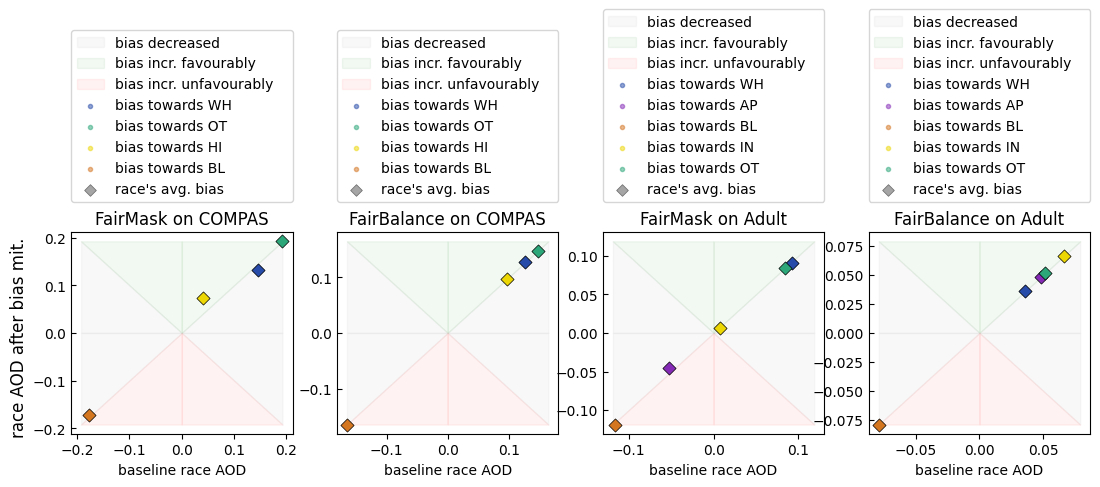

In [22]:
# Change in bias scale. (change in the absolute value of spd) HERE
reps = 3
metric = 'race|'+Metrics.AOD
m_to_eval = Metrics.AOD
plot_h = 2.3
Y_LABEL= " "
Y_LABELSUPER = "race AOD after bias mit."
X_LABEL= "baseline race AOD"
X_LABELSUPER = " "
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# TODO: make the values appear on top of the axis

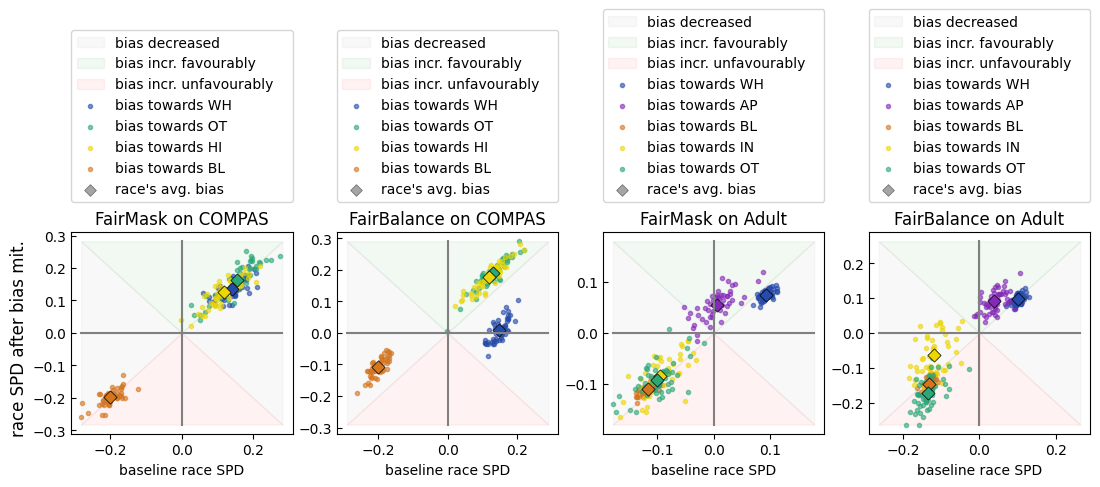

In [ ]:
# Change in bias scale. (change in the absolute value of spd) HERE
reps = 50
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
plot_h = 2.3
Y_LABEL= " "
Y_LABELSUPER = "race SPD after bias mit."
X_LABEL= "baseline race SPD"
X_LABELSUPER = " "
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# TODO: make the values appear on top of the axis

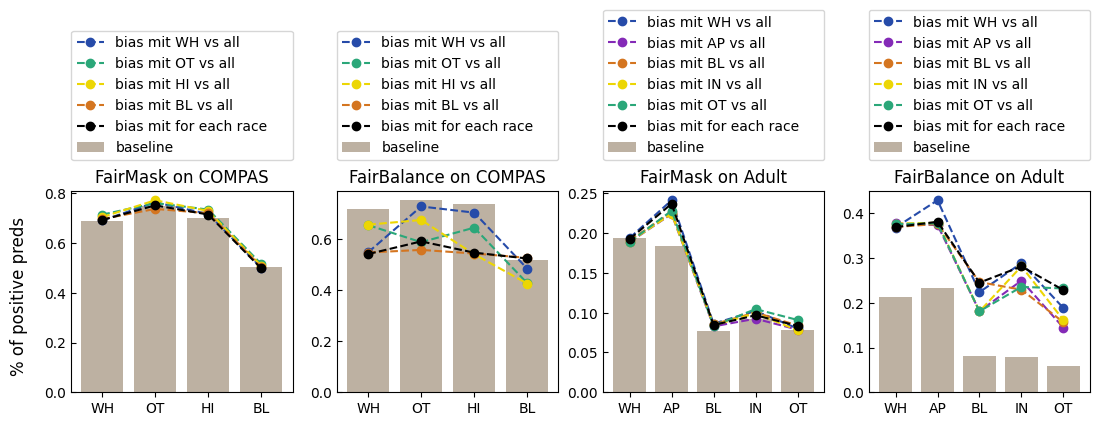

In [76]:
reps = 50

plot_h = 2.3
metric = Metrics.POS
Y_LABEL= " "
Y_LABELSUPER = "% of positive preds"
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])



In [ ]:
metric = 'race|'+Metrics.AOD
m_to_eval = Metrics.AOD
Y_LABELSUPER = "race AOD after bias mit."
X_LABEL= "baseline race AOD"
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])

In [ ]:
reps = 1
plot_h = 2.25
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric], attrs=["race", "sex"])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric], attrs=["race", "sex"])

In [ ]:
reps = 10
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

In [ ]:
reps = 1
metric = Metrics.EOD
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

In [ ]:
reps = 1
metric = Metrics.POS
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

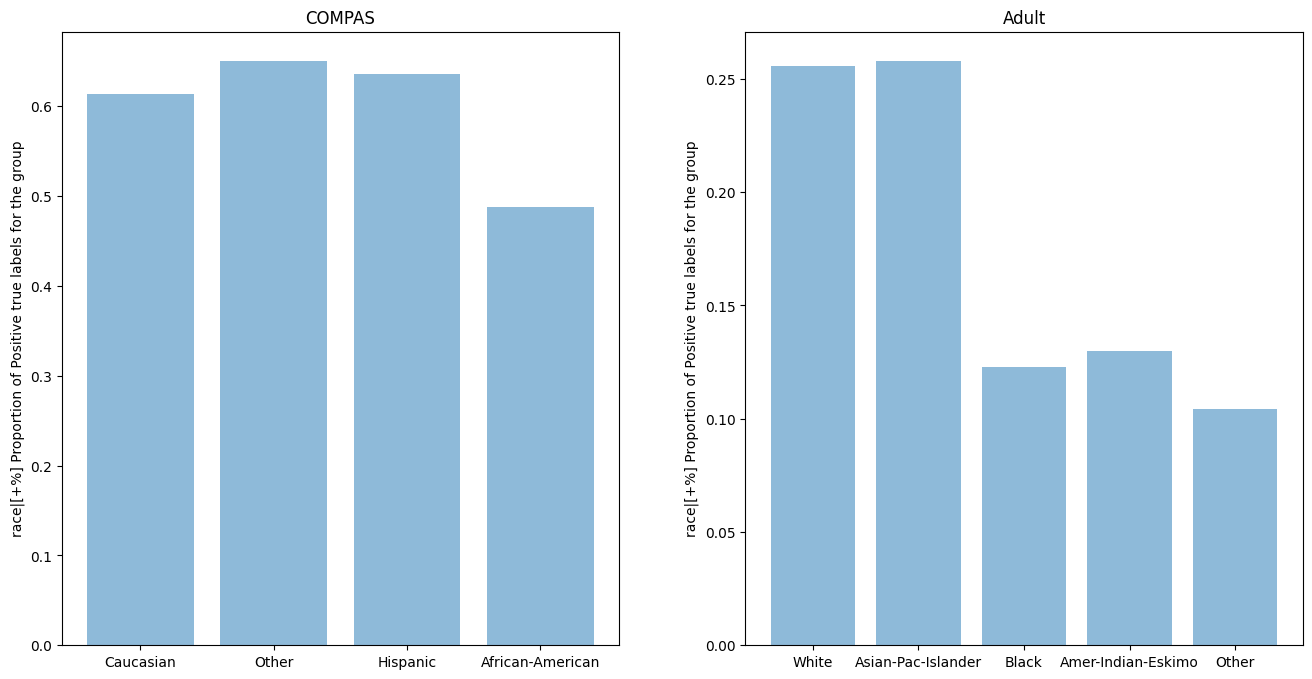

In [ ]:
reps = 15
metric = 'race|'+Metrics.T_POS
m_to_eval = Metrics.T_POS
run_fb_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])

In [ ]:
reps = 1
metric = Metrics.DF # 
m_to_eval = metric
run_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

In [ ]:
reps = 1
metric =  'race|'+Metrics.EOD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.EOD])

In [ ]:
reps = 1
metric =  'race|'+Metrics.DI
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.DI])

In [ ]:
reps = 1
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.SPD])

## RUNNING EXPERIMENTS WITH FEWER RACES

In [22]:
mls = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance merge races", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance merge races", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       "FairMask merge races",    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, "FairMask merge races",    other)
}

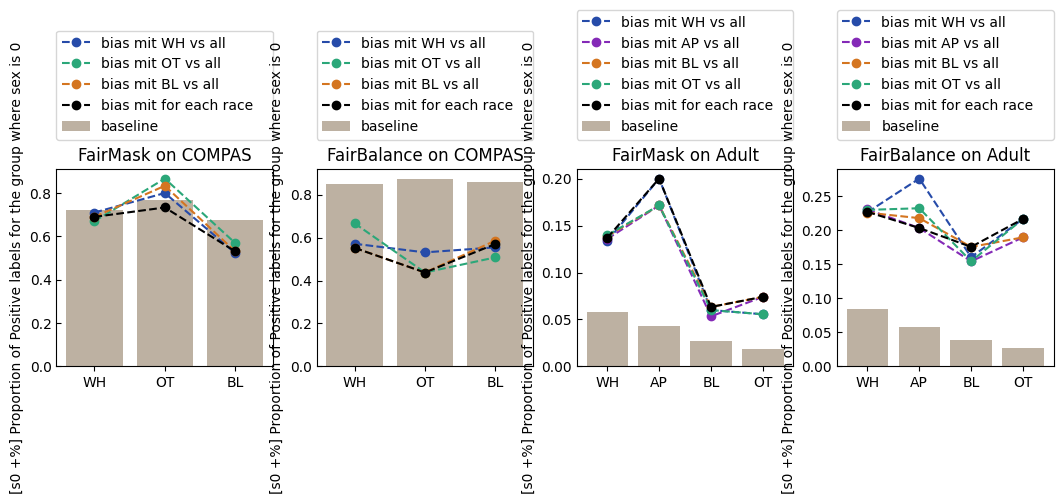

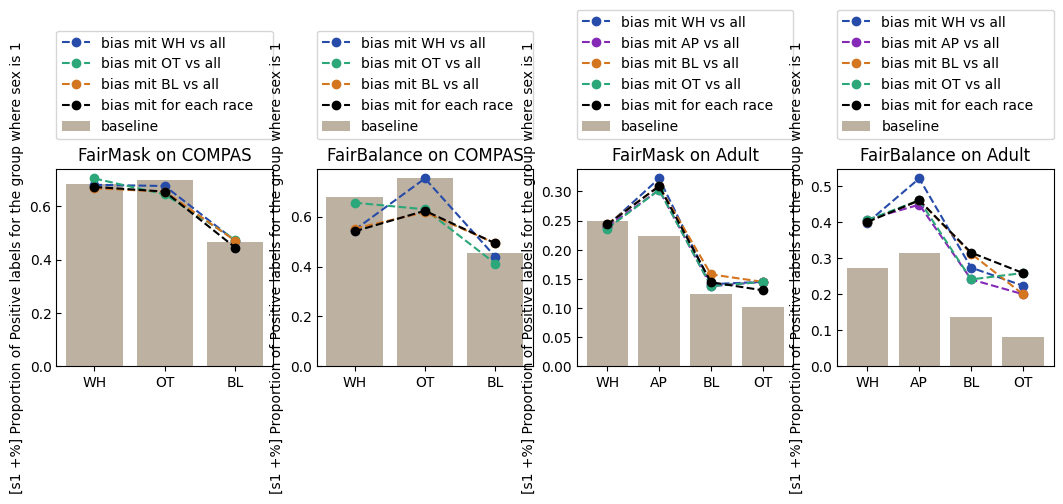

In [23]:
reps = 1
plot_h = 2.25
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, mls, metrics_to_eval=[metric], attrs=["race", "sex"])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, mls, metrics_to_eval=[metric], attrs=["race", "sex"])

KeyboardInterrupt: 

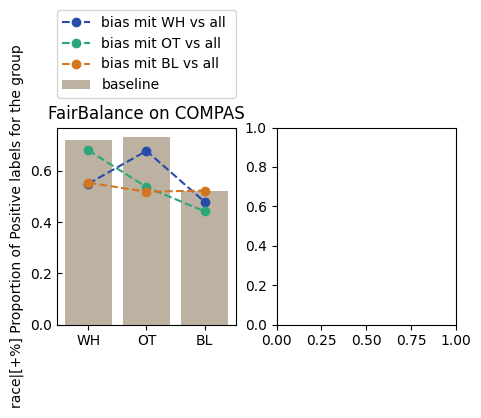

In [24]:
# proportion of positive lables for each race for one run
reps = 1
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_fb_experiment_group(reps, metric, mls, ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, mls, metrics_to_eval=[m_to_eval])